Right now, this is substantively identical to version 8 of Henrique Mendoça's RCNN model with Coco transfer learning (see fork link at the top).  The first version, which is an exact copy, got a LB score of 0.162.  I've edited the documentaiton and added the plot code here from his later version.   This version probably does not get such a high score, just because there is a lot of randomness between one run and another.

**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon
We get the best public kernel performance so far, and also training only within the 6hrs kaggle limit.

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [2]:
DATA_DIR = '/home/jyothsnakodandera/FinalProject_PDLS/data/rsna-pneumonia-data'
ROOT_DIR = './'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [3]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git
# os.chdir('Mask_RCNN')
#!python setup.py -q install

In [3]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ten

In [4]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [6]:
### Download COCO pre-trained weights
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 jyothsnakodandera jyothsnakodandera 246M Dec  6  2021 mask_rcnn_coco.h5


### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [7]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [8]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 1)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [10]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [11]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [12]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array
# show dicom fields 
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.29627.1517874492.886744
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29627.1517874492.886744
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [13]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [14]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.95 vs. 0.05 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(0.05 * len(image_fps_list))
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25350 1334


### Create and prepare the training dataset using the DetectorDataset class.

In [15]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [16]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

In [17]:
# Load and display random sample and their bounding boxes

# class_ids = [0]
# while class_ids[0] == 0:  ## look for a mask
#     image_id = random.choice(dataset_train.image_ids)
#     image_fp = dataset_train.image_reference(image_id)
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)

# print(image.shape)

# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# masked = np.zeros(image.shape[:2])
# for i in range(mask.shape[2]):
#     masked += image[:, :, 0] * mask[:, :, i]
# plt.imshow(masked, cmap='gray')
# plt.axis('off')

# print(image_fp)
# print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

In [17]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
# imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
# plt.figure(figsize=(30, 12))
# _ = plt.imshow(imggrid[:, :, 0], cmap='gray')

/opt/conda/envs/pytorch-build/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


### Now it's time to train the model. Note that training even a basic model can take a few hours. 


In [18]:
import keras
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [19]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


NameError: name 'COCO_WEIGHTS_PATH' is not defined

In [21]:
LEARNING_RATE = 0.005

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [23]:
time_callback = TimeHistory()
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=1,
            layers='heads',
            augmentation=None,
           custom_callbacks=[time_callback])
times = time_callback.times
times_list = []
times_list.append(times)
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.01

Checkpoint Path: ./pneumonia20221211T2038/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDi

2022-12-11 20:43:46.535161: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 20:43:46.535275: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 20:43:46.535308: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 20:43:46.535343: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

199/200 [============================>.] - ETA: 14s - loss: 1.7028 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.4206

2022-12-11 21:29:46.269846: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 21:29:46.269913: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_37. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 21:29:46.269930: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node proposal_targets/strided_slice_74. Error: ValidateStridedSliceOp returned partial shapes [1,?,?] and [?,?]
2022-12-11 21:29:46.269946: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer Arithm

200/200 [==============================] - 3014s 15s/step - loss: 1.7005 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.4615 - mrcnn_mask_loss: 0.4204 - val_loss: 2.1284 - val_rpn_class_loss: 0.0637 - val_rpn_bbox_loss: 0.7130 - val_mrcnn_class_loss: 0.3610 - val_mrcnn_bbox_loss: 0.5618 - val_mrcnn_mask_loss: 0.4289


In [24]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [3035.7905662059784]
{'val_loss': [2.1283920121192934], 'val_rpn_class_loss': [0.06365897387266159], 'val_rpn_bbox_loss': [0.7130287742614746], 'val_mrcnn_class_loss': [0.36096570432186126], 'val_mrcnn_bbox_loss': [0.5617988348007202], 'val_mrcnn_mask_loss': [0.42893780410289767], 'loss': [1.7004731869697571], 'rpn_class_loss': [0.0494216588884592], 'rpn_bbox_loss': [0.46535423580557106], 'mrcnn_class_loss': [0.3037443346530199], 'mrcnn_bbox_loss': [0.46150872483849525], 'mrcnn_mask_loss': [0.42044259533286094]}


In [45]:
time_callback = TimeHistory()
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=7,
            layers='all',
            augmentation=augmentation,
           custom_callbacks=[time_callback])

times = time_callback.times
times_list.append(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 0. LR=0.005

Checkpoint Path: ./pneumonia20221211T0532/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

InvalidArgumentError: indices[0] = 16362 is not in [0, 16320)
	 [[node ROI_2/GatherV2_2 (defined at home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/model.py:294) ]]

Errors may have originated from an input operation.
Input Source operations connected to node ROI_2/GatherV2_2:
 ROI_2/strided_slice_6 (defined at home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/utils.py:819)

Original stack trace for 'ROI_2/GatherV2_2':
  File "opt/conda/envs/pytorch-build/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "opt/conda/envs/pytorch-build/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "opt/conda/envs/pytorch-build/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "opt/conda/envs/pytorch-build/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "opt/conda/envs/pytorch-build/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
    cell_id=cell_id,
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
    raw_cell, store_history, silent, shell_futures, cell_id
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    return runner(coro)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_29840/148648432.py", line 1, in <module>
    model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
  File "home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/model.py", line 1965, in build
    config=config)([rpn_class, rpn_bbox, anchors])
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/model.py", line 296, in call
    names=["pre_nms_anchors"])
  File "home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/utils.py", line 820, in batch_slice
    output_slice = graph_fn(*inputs_slice)
  File "home/jyothsnakodandera/FinalProject_PDLS/masked-rcnn/exp2/Mask_RCNN/mrcnn/model.py", line 294, in <lambda>
    pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 3475, in gather
    return gen_array_ops.gather_v2(params, indices, axis, name=name)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4097, in gather_v2
    batch_dims=batch_dims, name=name)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "opt/conda/envs/pytorch-build/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [49]:
print('Epoch Training time:', times)
print(history)

{'val_loss': [1.539666006565094, 1.4354641103744508, 1.4388747859001159, 1.3694477522373198, 1.3945681548118591], 'val_rpn_class_loss': [0.04150051455944777, 0.03726499106734991, 0.03375799585133791, 0.0303593366779387, 0.035314059015363455], 'val_rpn_bbox_loss': [0.4235430935025215, 0.41399493515491487, 0.3692898827791214, 0.4242341086268425, 0.3850941848754883], 'val_mrcnn_class_loss': [0.28004062741994856, 0.2218485364317894, 0.2567757558822632, 0.1626374414563179, 0.23315046966075897], 'val_mrcnn_bbox_loss': [0.4280914199352264, 0.39991325795650484, 0.4070220082998276, 0.3809104681015015, 0.383866999745369], 'val_mrcnn_mask_loss': [0.36648010194301606, 0.3624313968420029, 0.37201721251010894, 0.3712937593460083, 0.3571290993690491], 'loss': [1.630573497414589, 1.4859343469142914, 1.449229816198349, 1.4084395080804826, 1.4040239164233208], 'rpn_class_loss': [0.04954254918731749, 0.041748126232996584, 0.03477288282476366, 0.03205885575618595, 0.03260616020299494], 'rpn_bbox_loss': [0

In [50]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation,
           custom_callbacks=[time_callback])

times = time_callback.times
times_list.append(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 7. LR=0.001

Checkpoint Path: /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [51]:
print('Epoch Training time:', times)
print(history)

{'val_loss': [1.2845248365402222, 1.326075977087021, 1.2497450017929077, 1.2574406504631042, 1.256157205104828, 1.2630465972423552, 1.2578339982032776, 1.2540998601913451], 'val_rpn_class_loss': [0.026643633656203747, 0.02828007297590375, 0.02490645498037338, 0.02482836341485381, 0.024375034999102353, 0.02462427329272032, 0.022659214232116937, 0.02545882949605584], 'val_rpn_bbox_loss': [0.34757002383470537, 0.37968476235866544, 0.3252993211150169, 0.34276214987039566, 0.3275559103488922, 0.35893029898405077, 0.3295386692881584, 0.366499160528183], 'val_mrcnn_class_loss': [0.17319305047392844, 0.18400524377822877, 0.18033866479992866, 0.1779482139647007, 0.1773434779047966, 0.16726559907197952, 0.17194708496332167, 0.1530036748945713], 'val_mrcnn_bbox_loss': [0.3708620202541351, 0.36518600314855576, 0.36148798525333403, 0.3595801654458046, 0.3632274740934372, 0.35478765666484835, 0.3690298438072205, 0.3496556428074837], 'val_mrcnn_mask_loss': [0.3662428277730942, 0.36890654802322387, 0.

In [25]:
times_list = [3100.942350625992, 2919.7681403160095, 3838.4051370620728, 3599.8287439346313, 3495.5102343559265, 3518.391268968582, 3519.0389177799225,\
              3478.5074512958527, 3487.1403295993805, 3517.974394083023, 3769.775235891342, 3505.0972604751587,\
              3472.0826065540314, 3501.41512465477, 3548.938042163849]

history = {'val_loss': [2.1349234700202944, 2.147835547924042, 2.4837684845924377, 1.8685538101196288, 2.0208426308631897, 1.7835288906097413, 2.1596428179740905, 1.845558943748474, 1.6052807068824768, 1.8365731835365295, 1.6694264531135559, 1.5303184461593629, 1.707759747505188, 1.7015903282165528, 1.7054264092445373], 'val_rpn_class_loss': [0.04658446967601776, 0.05706217020750046, 0.11906431913375855, 0.04865313470363617, 0.0641091126203537, 0.05134088814258576, 0.11253377944231033, 0.041337343454360964, 0.06361831873655319, 0.06697328984737397, 0.04519646793603897, 0.03301035538315773, 0.04317634582519531, 0.04615139797329903, 0.06197271704673767], 'val_rpn_bbox_loss': [0.7988203525543213, 0.7603895425796509, 1.0590975427627562, 0.6537582349777221, 0.8529054498672486, 0.6533264136314392, 0.8036744308471679, 0.6015525484085082, 0.37754886865615844, 0.6647035610675812, 0.4591502666473389, 0.4020089447498322, 0.6658352994918824, 0.6185073781013489, 0.5450826215744019], 'val_mrcnn_class_loss': [0.3001007318496704, 0.42004683524370195, 0.38407862454652786, 0.278115805387497, 0.2533662602305412, 0.2070675927400589, 0.3140053552389145, 0.28961500376462934, 0.2609559667110443, 0.2859273490309715, 0.3224626702070236, 0.2542493477463722, 0.23160688251256942, 0.21454885095357895, 0.2932953494787216], 'val_mrcnn_bbox_loss': [0.5343035399913788, 0.5152025067806244, 0.4825208222866058, 0.4738758391141891, 0.42918141186237335, 0.46791244208812716, 0.4871657419204712, 0.4820220875740051, 0.5082382065057754, 0.4476338052749634, 0.447416757941246, 0.44375345051288606, 0.3831925439834595, 0.434260288476944, 0.4139433282613754], 'val_mrcnn_mask_loss': [0.4551124614477158, 0.3951312863826752, 0.4389987939596176, 0.4141421568393707, 0.4212715005874634, 0.4038719892501831, 0.4422535026073456, 0.4310212141275406, 0.3949078291654587, 0.3713231307268143, 0.39518837332725526, 0.3972841930389404, 0.3839365237951279, 0.3881101757287979, 0.39111999213695525], 'loss': [1.6924433368444443, 1.6365146499872207, 1.5009415435791016, 1.4937750425934793, 1.5247445008158684, 1.436292625963688, 1.4406316682696343, 1.4023514473438263, 1.456989742219448, 1.4321323603391647, 1.4400130516290666, 1.3522206622362136, 1.366101324558258, 1.304487758874893, 1.3250547388195992], 'rpn_class_loss': [0.05106937070377171, 0.047678104992955925, 0.04178414295427501, 0.045540219824761155, 0.041070490051060914, 0.03939811036922038, 0.03917291934601962, 0.0381872689165175, 0.03830301174428314, 0.03800602498464287, 0.03868988418020308, 0.03379754251334816, 0.029579305206425488, 0.030042875772342086, 0.030249744141474365], 'rpn_bbox_loss': [0.45435774259269235, 0.4868608736619353, 0.385777458101511, 0.4335597462207079, 0.4180106008052826, 0.41113966137170793, 0.4168174934387207, 0.4032985591888428, 0.42667851962149145, 0.3842571173608303, 0.3919811151176691, 0.3349699617177248, 0.35824386671185493, 0.3409699536859989, 0.38090036988258363], 'mrcnn_class_loss': [0.3177102542668581, 0.296053314357996, 0.2714362735301256, 0.24562902595847846, 0.2793010775744915, 0.2359589432179928, 0.22086567215621472, 0.2381404500454664, 0.2476743443310261, 0.23599101148545742, 0.24394403472542764, 0.2418520660698414, 0.22107554625719786, 0.20274938840419054, 0.19967874679714442], 'mrcnn_bbox_loss': [0.45967494644224643, 0.420139332190156, 0.4038297978788614, 0.38631139136850834, 0.40236317917704584, 0.3724007372558117, 0.3804102852195501, 0.3517476116120815, 0.37148970536887643, 0.39076235875487325, 0.38799280911684036, 0.3714153411984444, 0.3808877325057983, 0.3577812670171261, 0.3508153384923935], 'mrcnn_mask_loss': [0.40962940737605097, 0.38578060701489447, 0.3981056097149849, 0.38272617995738983, 0.38399034455418585, 0.3773859353363514, 0.38335548907518385, 0.37096726313233375, 0.37283308237791063, 0.3831042113900185, 0.3773932348191738, 0.370173719227314, 0.3763026627898216, 0.3729320442676544, 0.36339816957712173]}

In [28]:
epochs = range(1,len(next(iter(history.values())))+1)
df = pd.DataFrame(history, index=epochs)
df['epoch_train_time'] = times_list
df.to_csv(ROOT_DIR + 'exp2-loss.csv')

In [31]:
df.head()

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,epoch_train_time
1,2.134923,0.046584,0.798820,0.300101,0.534304,0.455112,1.692443,0.051069,0.454358,0.317710,0.459675,0.409629,3100.942351
2,2.147836,0.057062,0.760390,0.420047,0.515203,0.395131,1.636515,0.047678,0.486861,0.296053,0.420139,0.385781,2919.768140
3,2.483768,0.119064,1.059098,0.384079,0.482521,0.438999,1.500942,0.041784,0.385777,0.271436,0.403830,0.398106,3838.405137
4,1.868554,0.048653,0.653758,0.278116,0.473876,0.414142,1.493775,0.045540,0.433560,0.245629,0.386311,0.382726,3599.828744
5,2.020843,0.064109,0.852905,0.253366,0.429181,0.421272,1.524745,0.041070,0.418011,0.279301,0.402363,0.383990,3495.510234


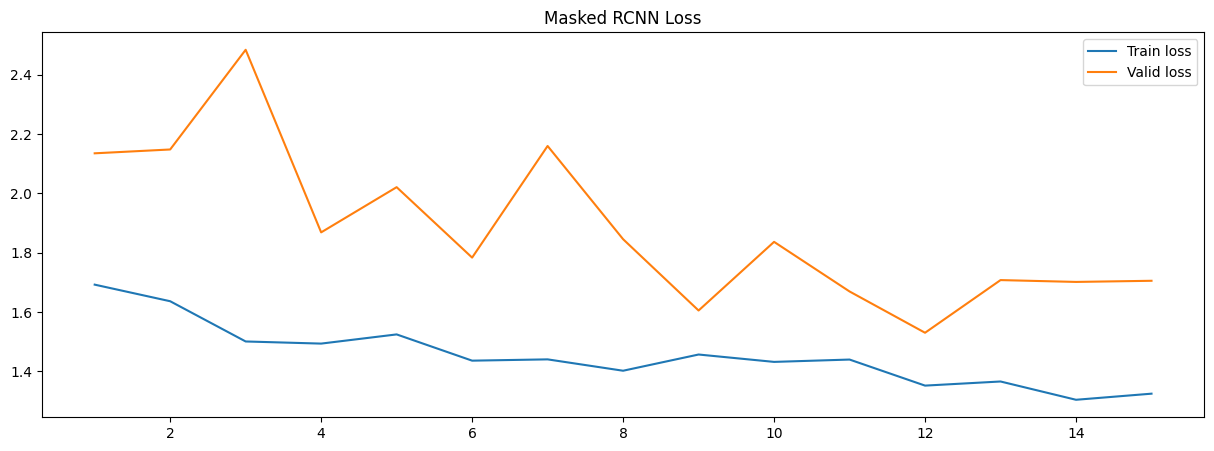

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.title('Masked RCNN Loss')
plt.legend()
plt.savefig('exp2-mrccn-loss-plot.png')
# plt.show()

In [20]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model ./pneumonia20221212T0116/mask_rcnn_pneumonia_0015.h5


In [21]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  ./pneumonia20221212T0116/mask_rcnn_pneumonia_0015.h5


2022-12-12 19:13:36.767625: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-12 19:13:36.772623: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2022-12-12 19:13:36.773670: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x560c7c718dc0 executing computations on platform Host. Devices:
2022-12-12 19:13:36.773700: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Re-starting from epoch 15


### Final steps - Create the submission file

In [22]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [23]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.95.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.95)
print(submission_fp)

 51%|██████████████████████████████████████████████████████████████████████▎                                                                  | 1539/3000 [13:20<12:12,  1.99it/s]

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.5.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.5)
print(submission_fp)

In [ ]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.3.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.3)
print(submission_fp)